## Import Necessary Libraries

In [23]:
import re
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Loading the Dataset

In [14]:
# Import the pandas library for data manipulation
import pandas as pd

# Load the CSV file into a pandas DataFrame
# The file 'taghche.csv' is located in the 'datasets/' directory
data = pd.read_csv('datasets/taghche.csv')

# Remove any duplicate rows in the DataFrame
data = data.drop_duplicates()

# Drop rows where the 'comment' or 'rate' columns have missing values (NaN)
data.dropna(subset=['comment', 'rate'], inplace=True)

# Print the first 5 rows of the cleaned DataFrame
print(data.head())

,date,comment,bookname,rate,bookID,like
0,1395/11/14,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,0.0,3.0,2.0
1,1395/11/14,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,2.0
2,1394/06/06,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,0.0
3,1393/09/02,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,2.0,3.0,0.0
4,1393/06/29,کتاب خوبی است,سرهنگ کسی ندارد برایش نامه بنویسد,3.0,3.0,0.0


In [15]:
# Function to label the sentiment based on rating thresholds
def label_sentiment(rate, positive_threshold, neutral_threshold):
    """
    Labels sentiment based on rating thresholds.

    Args:
    - rate (int or float): The numerical rating to evaluate.
    - positive_threshold (int or float): The minimum rating value that qualifies as 'positive'.
    - neutral_threshold (int or float): The minimum rating value that qualifies as 'neutral'; ratings below this are considered 'negative'.

    Returns:
    - str: The sentiment label ('positive', 'neutral', or 'negative') based on the rating.
    """
    # Check if the rating is greater than or equal to the positive threshold
    if rate >= positive_threshold:
        return 'positive'
    # If the rating is not 'positive', check if it is greater than or equal to the neutral threshold
    elif rate >= neutral_threshold:
        return 'neutral'
    # If the rating is neither 'positive' nor 'neutral', label the sentiment as 'negative'
    else:
        return 'negative'

## Balancing Dataset

In [16]:
# Function to prepare data and labels based on given thresholds
def prepare_data(positive_threshold, neutral_threshold):
    """
    Prepares the data and labels based on given thresholds for sentiment classification.

    Args:
    - positive_threshold (int or float): The minimum rating value that qualifies as 'positive'.
    - neutral_threshold (int or float): The minimum rating value that qualifies as 'neutral'; ratings below this are considered 'negative'.

    Returns:
    - tuple: A tuple containing:
        - pandas.Series: The comments from the balanced dataset.
        - pandas.Series: The corresponding sentiment labels from the balanced dataset.
    """
    # Create a copy of the original data to avoid modifying it
    labeled_data = data.copy()
    
    # Apply the label_sentiment function to the 'rate' column to create a new 'sentiment' column
    labeled_data['sentiment'] = labeled_data['rate'].apply(lambda x: label_sentiment(x, positive_threshold, neutral_threshold))
    
    # Combine the 'comment' and 'sentiment' columns into a single DataFrame
    df = pd.concat([labeled_data['comment'], labeled_data['sentiment']], axis=1)

    # Separate the DataFrame into three classes based on sentiment
    positive = df[df['sentiment'] == 'positive']
    neutral = df[df['sentiment'] == 'neutral']
    negative = df[df['sentiment'] == 'negative']

    # Determine the size of the smallest class to balance the dataset
    min_class_size = min(len(positive), len(neutral), len(negative))

    # Downsample each class to the size of the smallest class to ensure balance
    positive_downsampled = resample(positive, replace=False, n_samples=min_class_size, random_state=42)
    neutral_downsampled = resample(neutral, replace=False, n_samples=min_class_size, random_state=42)
    negative_downsampled = resample(negative, replace=False, n_samples=min_class_size, random_state=42)

    # Combine the downsampled classes into a single DataFrame
    df_balanced = pd.concat([positive_downsampled, neutral_downsampled, negative_downsampled])

    # Shuffle the balanced DataFrame to mix the rows
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Return the 'comment' and 'sentiment' columns as separate pandas Series
    return df_balanced['comment'], df_balanced['sentiment']

## Preprocess

In [17]:
# Function to preprocess and normalize the text
def preprocess(text):
    """
    Preprocesses and normalizes text data by removing special characters,
    non-Persian characters, digits, and multiple spaces.

    Args:
    - text (str): Input text to be processed.

    Returns:
    - str: Processed text with normalized format.
    """
    # Replace one or more newline characters with a single newline
    pattern = re.compile(r"\n+")
    text = pattern.sub("\n", text)
    
    # Replace '\n' and '\n' with a single space
    text = re.sub(r'\\n|\n', ' ', text)
    
    # Remove non-Persian characters and digits
    text = re.sub(r'[^آ-ی\s]', ' ', text)
    
    # Replace one or more spaces with a single space
    pattern = re.compile(r" +")
    text = pattern.sub(" ", text)
    
    return text

# Apply the preprocess function to the 'comment' column in the DataFrame data
data['comment'] = data['comment'].apply(preprocess)

In [18]:
# Remove any duplicate rows in the DataFrame
data = data.drop_duplicates()

# Drop rows where the 'comment' or 'rate' columns have missing values (NaN)
data.dropna(subset=['comment', 'rate'], inplace=True)

## TF-IDF Vectorizer - Logistic Regression

In [30]:
# Create a pipeline with TF-IDF and logistic regression
logReg_PL = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(max_iter=500, solver='newton-cg'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [5000, 10000],
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Custom GridSearchCV implementation to iterate over parameter grid
best_score = 0
best_params = None

# Thresholds to evaluate
rate_thresholds = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

# Iterate over each pair of thresholds and perform GridSearchCV
for neutral_threshold, positive_threshold in tqdm(rate_thresholds):
    # Prepare the data using the specified thresholds
    X_prepared, y_prepared = prepare_data(positive_threshold, neutral_threshold)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.1, random_state=42)
    
    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(logReg_PL, param_grid, cv=5, scoring='accuracy')
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best score and parameters from GridSearchCV
    score = grid_search.best_score_
    
    # Update the best score and best parameters if the current score is better
    if score > best_score:
        best_score = score
        best_params = grid_search.best_params_
        best_params['positive_threshold'] = positive_threshold
        best_params['neutral_threshold'] = neutral_threshold

# Print the best parameters found by GridSearchCV
print("Best parameters for TF-IDF model are:", best_params)

100%|██████████| 6/6 [29:22<00:00, 293.78s/it]

Best parameters for TF-IDF model are: {'logreg__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'positive_threshold': 4, 'neutral_threshold': 2}


In [31]:
# Prepare the data using the best parameters found from GridSearchCV
X_prepared, y_prepared = prepare_data(best_params['positive_threshold'], best_params['neutral_threshold'])

# Split the prepared data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y_prepared, test_size=0.1, random_state=42)

# Create a pipeline for the best Logistic Regression model with the best parameters
best_logReg_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=best_params['tfidf__ngram_range'], max_features=best_params['tfidf__max_features'])),
    ("logreg", LogisticRegression(C=best_params['logreg__C'], max_iter=500, solver='newton-cg'))
])

# Fit the best Logistic Regression model on the training data
best_logReg_model.fit(X_train, y_train)

# Predict the labels on the test set using the best model
y_test_pred = best_logReg_model.predict(X_test)

# Calculate the accuracy score of the best model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the test accuracy score of the best Logistic Regression model
print("Test accuracy of Logistic Regression model:", test_accuracy)

Test accuracy of Logistic Regression model:  0.614314115308151


## Results and Evaluation Metrics

Classification Report:
               precision    recall  f1-score      support
Negative       0.576887  0.623992  0.599516   992.000000
Neutral        0.592161  0.557884  0.574512  1002.000000
Positive       0.675325  0.660156  0.667654  1024.000000
accuracy       0.614314  0.614314  0.614314     0.614314
macro avg      0.614791  0.614011  0.613894  3018.000000
weighted avg   0.615358  0.614314  0.614333  3018.000000


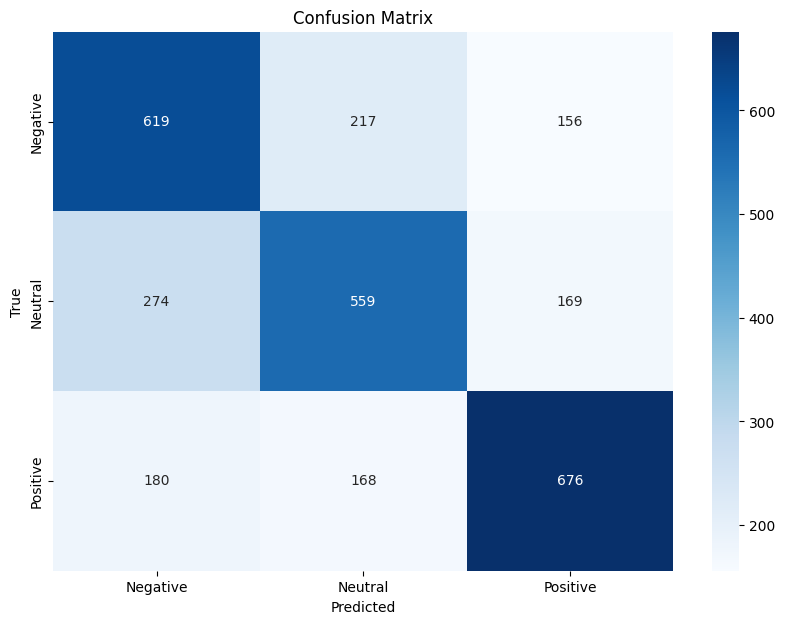


Overall Metrics:
Accuracy: 0.6143
Precision: 0.6154
Recall: 0.6143
F1 Score: 0.6143


In [32]:
def evaluate_model(y_true, y_pred, class_names):
    """
    Evaluates the performance of a classification model using various metrics and visualizations.

    Args:
    - y_true (array-like): True labels of the data.
    - y_pred (array-like): Predicted labels of the data.
    - class_names (list): List of class names in the same order as the confusion matrix.

    Returns:
    - pd.DataFrame: DataFrame containing the classification report.
    """
    # Generate and print the classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:\n", report_df)

    # Generate and display the confusion matrix as a heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print overall metrics: accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    print("\nOverall Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return report_df

# Evaluate the model
report_df = evaluate_model(y_test, y_test_pred, ["Negative", "Neutral", "Positive"])